<a href="https://colab.research.google.com/github/TripathiAshutosh/tumorClassification/blob/master/ExplainableML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.9/547.9 kB 5.5 MB/s eta 0:00:00


In [4]:
pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 5.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=20a5a730d5fbfae5fe9110dd46484244a965b7146eab9e78bdb6e6d7abd9a8d6
  Stored in directory: /root/.cache/pip/wheels/fd/a2/af/9ac0a1a85a27f314a06b39e1f492bee1547d52549a4606ed89
Successfully built lime


# 1. Imports and Parameters

In [5]:
from __future__ import print_function, division

import os
import io
import requests
import random
import time
import numpy as np
import copy
import cv2
import pdb
import shap
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import matplotlib.pyplot as plt
import itertools

from PIL import Image
from sklearn.metrics import classification_report, confusion_matrix
from skimage.segmentation import mark_boundaries
from torchvision import models, transforms, datasets
from torch.autograd import Variable
from torch.nn import functional as F
from lime import lime_image

plt.ion()   # interactive mode
random.seed(42)

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [ ]:
# data dir
DATA_DIR = os.path.join("data", "hymenoptera_data")

# model parameters
MODEL_NAME = "resnext101"
NUM_CLASSES = 2
FIXED_FEATURE_EXTRACTOR = True # True --> Base model weights fixed

# input size of image
INPUT_SIZE = (460, 460)

# data parameters
BATCH_SIZE = 30
SHUFFLE = True
NUM_WORKERS = 0

# optimizer hyperparameters
LEARNING_RATE = 0.001
USE_ADAM_OPTIM = True

# SGD optimizer hyperparameters
MOMENTUM = 0.9

# Adam optimizer hyperparameters
BETA_1 = 0.9
BETA_2 = 0.999
EPSILON = 1e-08
WEIGHT_DECAY = 1e-5 #0.0

# training hyperparameters
NUM_EPOCHS = 25

# lr learning rate scheduler hyperparameters
DECAY_STEP_SIZE = 5
GAMMA = 0.1

# cyclic learning rate scheduler hyperparameters
BASE_LR = 0.001
MAX_LR = 0.005
STEP_SIZE_UP = 2000
STEP_SIZE_DOWN = None
MODE_CYCLIC = "triangular" # "triangular2" or "exp_range"

# ReduceLROnPlateau learning rate scheduler hyperparameters
MODE_PLATEAU = "min" # "max"
FACTOR = 0.1
PATIENCE = 2
COOLDOWN = 0
MIN_LR = 0

# other
RANDOM = 42

# 2. Check device

In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

# 3. Select and Load Model

In [16]:
def initialize_model(model_name, num_classes, feature_extract, custom_input_size, use_pretrained=True):
    # Initialize these variables which will be set in this if statement. Each of these variables is model specific.
    model = None
    input_size = 0
    finalconv_name = ""

    if model_name == "densenet161":
        """ Densenet
        """
        model = models.densenet161(pretrained=use_pretrained)
        set_parameter_requires_grad(model, feature_extract)
        num_ftrs = model.classifier.in_features
        model.classifier = nn.Linear(num_ftrs, num_classes)
        input_size = (224, 224)
        finalconv_name = "features"

    elif model_name == "resnet152":
        """ Resnet152
        """
        model = models.resnet152(pretrained=use_pretrained)
        set_parameter_requires_grad(model, feature_extract)
        num_ftrs = model.fc.in_features
        model.fc = nn.Linear(num_ftrs, num_classes)
        input_size = (224, 224)
        finalconv_name = "layer4"

    elif model_name == "resnet101":
        """ Resnet101
        """
        model = models.resnet101(pretrained=use_pretrained)
        set_parameter_requires_grad(model, feature_extract)
        num_ftrs = model.fc.in_features
        model.fc = nn.Linear(num_ftrs, num_classes)
        input_size = (224, 224)
        finalconv_name = "layer4"

    elif model_name == "inception":
        """ Inception v3
        Be careful, expects (299,299) sized images and has auxiliary output
        """
        model = models.inception_v3(pretrained=use_pretrained)
        set_parameter_requires_grad(model, feature_extract)
        # Handle the auxilary net
        num_ftrs = model.AuxLogits.fc.in_features
        model.AuxLogits.fc = nn.Linear(num_ftrs, num_classes)
        # Handle the primary net
        num_ftrs = model.fc.in_features
        model.fc = nn.Linear(num_ftrs,num_classes)
        input_size = (299, 299)
        finalconv_name = "Mixed_7c"

    elif model_name == "resnext50":
        """ ResNext50
        """
        model = models.resnext50_32x4d(pretrained=use_pretrained)
        set_parameter_requires_grad(model, feature_extract)
        num_ftrs = model.fc.in_features
        model.fc = nn.Linear(num_ftrs, num_classes)
        input_size = (224, 224)
        finalconv_name = "layer4"

    elif model_name == "resnext101":
        """ ResNext101
        """
        model = models.resnext101_32x8d(pretrained=use_pretrained)
        set_parameter_requires_grad(model, feature_extract)
        num_ftrs = model.fc.in_features
        model.fc = nn.Linear(num_ftrs, num_classes)
        input_size = (224, 224)
        finalconv_name = "layer4"

    else:
        print("Invalid model name")
        exit()

    # Gather the parameters to be optimized/updated in this run.
    params_to_update = set_params_to_update(model, feature_extract)

    # Overwrite input size, if custom input size is set in parameters
    if (not INPUT_SIZE[0] is None) and (not INPUT_SIZE[1] is None):
        input_size = custom_input_size

    return model, input_size, params_to_update, finalconv_name

def set_parameter_requires_grad(model, feature_extract):
    if feature_extract:
        for param in model.parameters():
            param.requires_grad = False

def set_params_to_update(model, feature_extract):
    params_to_update = []
    if feature_extract:
        for param in model.parameters():
            if param.requires_grad == True:
                params_to_update.append(param)
    else:
        params_to_update = model.parameters()
    return params_to_update

In [ ]:
# Initialize the model for this run
net, input_size, params_to_update, finalconv_name = initialize_model(MODEL_NAME, NUM_CLASSES, FIXED_FEATURE_EXTRACTOR, INPUT_SIZE)

# Send the model to GPU
net = net.to(device)

# Print the initiated model
print(net)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
      (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stri

# 4. Load Data

In [ ]:
class RandomDiscreteRotation(object):
    def __init__(self, angles):
        self.discrete_angles = angles

    def __call__(self, img):
        angle = random.choice(self.discrete_angles)
        return transforms.functional.rotate(img, angle)

In [ ]:
# old
"""
# define data transformations
data_transforms = {
    "train": transforms.Compose([
        transforms.RandomResizedCrop(input_size, scale=(0.8, 1.0)),
        transforms.ColorJitter(brightness=0.05, contrast=0.05, saturation=0.05, hue=0.05),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        #transforms.RandomRotation(5),
        RandomDiscreteRotation([0, 90, 180, 270]),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    "val": transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    "test": transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}
"""
print()

In [ ]:
# define data transformations
data_transforms = {
    "train": transforms.Compose([
        transforms.Resize(input_size),
        transforms.ColorJitter(brightness=0.05, contrast=0.05, saturation=0.05, hue=0.05),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        RandomDiscreteRotation([0, 90, 180, 270]), # TODO --> depending on input size
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    "val": transforms.Compose([
        transforms.Resize(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    "test": transforms.Compose([
        transforms.Resize(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [ ]:
# create datasets
image_datasets = {x: datasets.ImageFolder(os.path.join(DATA_DIR, x), data_transforms[x])
                  for x in ["train", "val", "test"]}
image_datasets

{'test': Dataset ImageFolder
     Number of datapoints: 79
     Root location: data/hymenoptera_data/test, 'train': Dataset ImageFolder
     Number of datapoints: 254
     Root location: data/hymenoptera_data/train, 'val': Dataset ImageFolder
     Number of datapoints: 64
     Root location: data/hymenoptera_data/val}

In [ ]:
# create dataloaders
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=BATCH_SIZE, shuffle=SHUFFLE, num_workers=NUM_WORKERS)
              for x in ["train", "val", "test"]}
dataloaders

{'test': <torch.utils.data.dataloader.DataLoader at 0x7f81202c3048>,
 'train': <torch.utils.data.dataloader.DataLoader at 0x7f81fc051f28>,
 'val': <torch.utils.data.dataloader.DataLoader at 0x7f81fc051a90>}

In [ ]:
class_names = image_datasets["train"].classes
class_names

['ants', 'bees']

Visualize some images from the training set to understand data augmentations.

In [ ]:
def imshow(images, title=None):
    """Imshow for Tensor."""
    images = images.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    images = std * images + mean
    images = np.clip(images, 0, 1)
    plt.figure(figsize=(16,10))
    plt.imshow(images)
    if title is not None:
        plt.title(title)
    #plt.pause(0.001)  # pause a bit so that plots are updated
    plt.show()

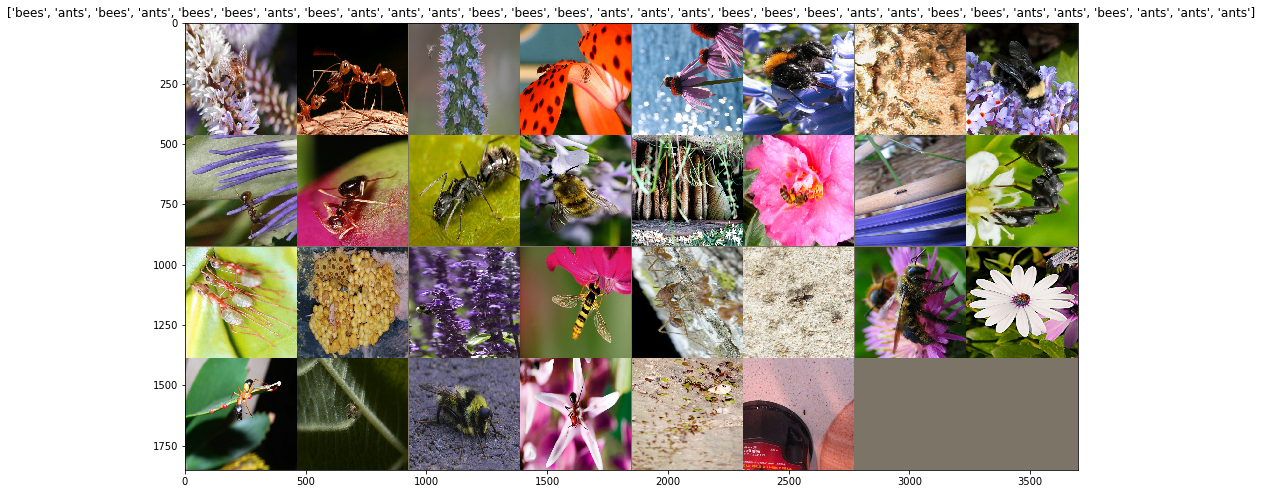

In [ ]:
# Get a batch of training data
inputs, classes = next(iter(dataloaders["train"]))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

# 5. Train Model

In [ ]:
def train_model(model, dataloaders, criterion, optimizer, scheduler, num_epochs=25, is_inception=False):
    # start time for tracking training time
    since = time.time()

    # list for tracking
    val_acc_history = []
    val_loss_history = []
    train_acc_history = []
    train_loss_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print("Epoch {}/{}".format(epoch, num_epochs - 1))
        print("-" * 10)

        for phase in ["train", "val"]:
            if phase == "train":
                #scheduler.step()
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == "train"):
                    # Special case for inception because in training it has an auxiliary output. In train
                    #   mode we calculate the loss by summing the final output and the auxiliary output
                    #   but in testing we only consider the final output.
                    if is_inception and phase == "train":
                        # From https://discuss.pytorch.org/t/how-to-optimize-inception-model-with-auxiliary-classifiers/7958
                        outputs, aux_outputs = model(inputs)
                        loss1 = criterion(outputs, labels)
                        loss2 = criterion(aux_outputs, labels)
                        loss = loss1 + 0.4*loss2
                    else:
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    if phase == "train":
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print("{} Loss: {:.4f} Acc: {:.4f}".format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == "val" and train_acc_history[-1] > 0.9 and epoch_acc >= best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == "train":
                train_acc_history.append(epoch_acc)
                train_loss_history.append(epoch_loss)
            if phase == "val":
                scheduler.step(epoch_loss)
                val_acc_history.append(epoch_acc)
                val_loss_history.append(epoch_loss)

        print()

    time_elapsed = time.time() - since
    print("Training complete in {:.0f}m {:.0f}s".format(time_elapsed // 60, time_elapsed % 60))
    print("Best val Acc: {:4f}".format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history, val_loss_history, train_acc_history, train_loss_history

In [ ]:
# define optimizer
if USE_ADAM_OPTIM:
    optimizer = optim.Adam(params_to_update, lr=LEARNING_RATE, betas=(BETA_1, BETA_2), eps=EPSILON, weight_decay=WEIGHT_DECAY)
else:
    optimizer = optim.SGD(params_to_update, lr=LEARNING_RATE, momentum=MOMENTUM)

# define objective
if NUM_CLASSES <= 2:
    objective = nn.CrossEntropyLoss() #nn.BCELoss()
else:
    objective = nn.CrossEntropyLoss()

# define learning rate scheduler
#lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=DECAY_STEP_SIZE, gamma=GAMMA)
#lr_scheduler = optim.lr_scheduler.CyclicLR(optimizer, base_lr=BASE_LR, max_lr=MAX_LR, step_size_up=STEP_SIZE_UP, step_size_down=STEP_SIZE_DOWN, mode=MODE_CYCLIC)
lr_scheduler =  optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode=MODE_PLATEAU, factor=FACTOR, patience=PATIENCE, verbose=False, cooldown=COOLDOWN, min_lr=MIN_LR)

In [ ]:
# train model
net, val_acc_history, val_loss_history, train_acc_history, train_loss_history = train_model(net, dataloaders, objective, optimizer, lr_scheduler, num_epochs=NUM_EPOCHS, is_inception=(MODEL_NAME=="inception"))

Epoch 0/24
----------
train Loss: 0.6676 Acc: 0.5551
val Loss: 0.4708 Acc: 0.9375

Epoch 1/24
----------
train Loss: 0.5448 Acc: 0.6772
val Loss: 0.4454 Acc: 0.7344

Epoch 2/24
----------
train Loss: 0.3837 Acc: 0.8504
val Loss: 0.2809 Acc: 0.9375

Epoch 3/24
----------
train Loss: 0.2997 Acc: 0.9213
val Loss: 0.2357 Acc: 0.9531

Epoch 4/24
----------
train Loss: 0.2685 Acc: 0.9213
val Loss: 0.1957 Acc: 0.9531

Epoch 5/24
----------
train Loss: 0.2219 Acc: 0.9528
val Loss: 0.1839 Acc: 0.9531

Epoch 6/24
----------
train Loss: 0.2263 Acc: 0.9409
val Loss: 0.1587 Acc: 0.9688

Epoch 7/24
----------
train Loss: 0.1936 Acc: 0.9528
val Loss: 0.1519 Acc: 0.9531

Epoch 8/24
----------
train Loss: 0.2175 Acc: 0.9252
val Loss: 0.1379 Acc: 0.9688

Epoch 9/24
----------
train Loss: 0.2473 Acc: 0.8976
val Loss: 0.1228 Acc: 0.9688

Epoch 10/24
----------
train Loss: 0.2706 Acc: 0.8740
val Loss: 0.1440 Acc: 0.9531

Epoch 11/24
----------
train Loss: 0.2406 Acc: 0.9055
val Loss: 0.1061 Acc: 0.9688

Ep

In [ ]:
def plot_loss(train_loss, val_loss):
    # Get num of epochs
    epochs = np.arange(0, len(train_loss)) + 1

    # Plot loss history
    plt.figure(figsize=(10, 10))
    plt.plot(epochs, train_loss, "r--")
    plt.plot(epochs, val_loss, "b-")
    plt.legend(["Training Loss", "Test Loss"])
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.show()

def plot_accuracy(train_accuracy, val_accuracy):
    # Get num of epochs
    epochs = np.arange(0, len(train_accuracy)) + 1

    # Plot loss history
    plt.figure(figsize=(10, 10))
    plt.plot(epochs, train_accuracy, "r--")
    plt.plot(epochs, val_accuracy, "b-")
    plt.legend(["Training Accuracy", "Test Accuracy"])
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.show()

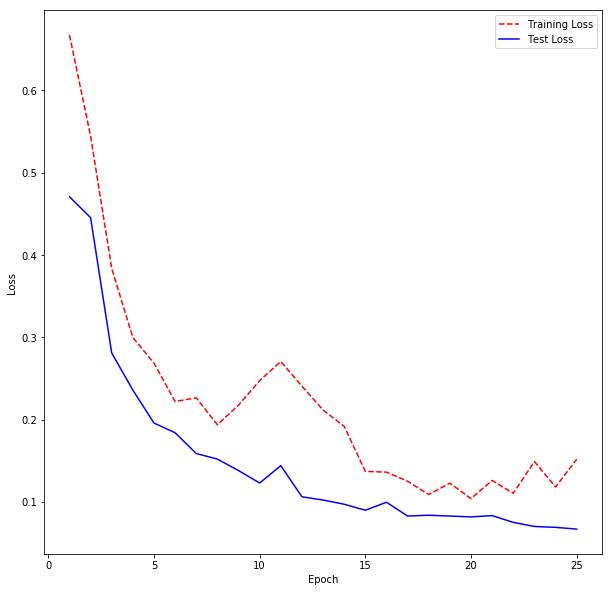

In [ ]:
plot_loss(train_loss_history, val_loss_history)

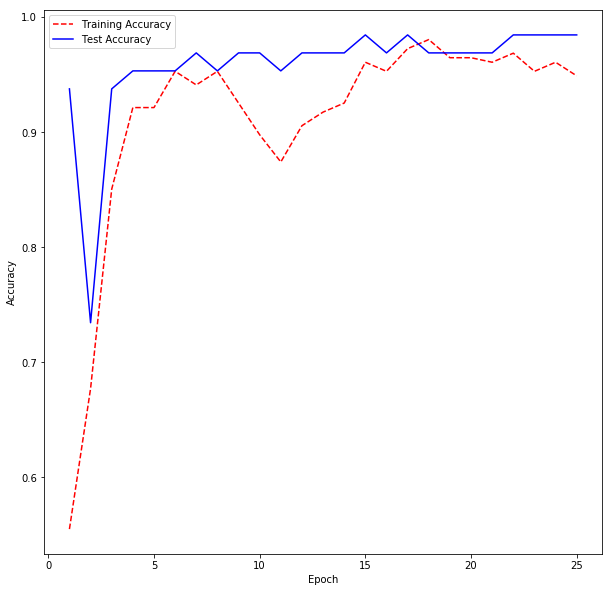

In [ ]:
plot_accuracy(train_acc_history, val_acc_history)

# 6. Evaluate Model on Test Data

In [ ]:
net.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
      (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stri

In [ ]:
def get_test_results(model, dataloader):
    label = np.array([])
    label_predicted = np.array([])

    for batch_idx, (inputs, labels) in enumerate(dataloader):
        inputs = inputs.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)

        # append labels
        label = np.append(label, labels.numpy())
        label_predicted = np.append(label_predicted, preds.cpu().numpy())

    return label, label_predicted

In [ ]:
label, label_predicted = get_test_results(net, dataloaders["test"])
len(label), len(label_predicted)

(79, 79)

In [ ]:
label_list = label.tolist()
label_predicted_list = label_predicted.tolist()

# create a classification report
print(classification_report(label_list, label_predicted_list, target_names=class_names))

              precision    recall  f1-score   support

        ants       0.97      1.00      0.99        38
        bees       1.00      0.98      0.99        41

   micro avg       0.99      0.99      0.99        79
   macro avg       0.99      0.99      0.99        79
weighted avg       0.99      0.99      0.99        79



Confusion matrix, without normalization
[[38  0]
 [ 1 40]]


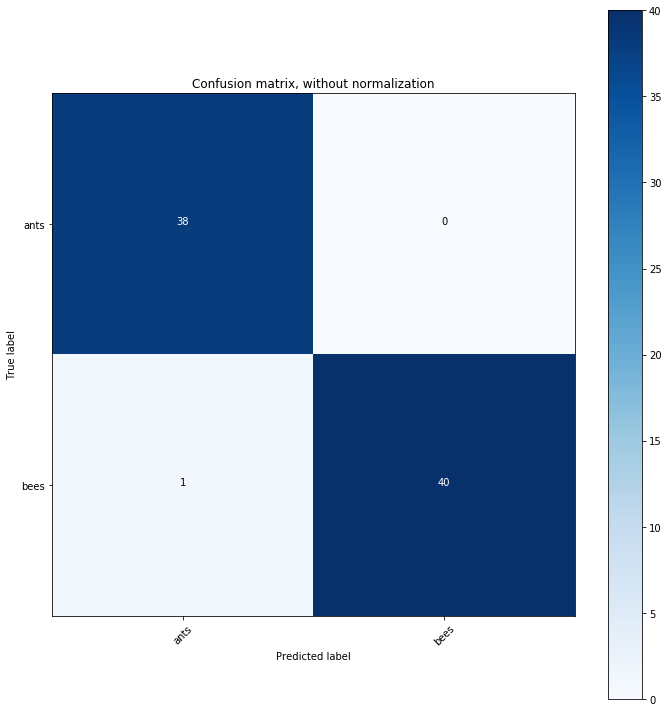

In [ ]:
# create and display a confusion matrix
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

# Compute confusion matrix
cnf_matrix = confusion_matrix(label_list, label_predicted_list)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize=(10, 10))
plot_confusion_matrix(cnf_matrix, classes=class_names, title='Confusion matrix, without normalization')
display()

Normalized confusion matrix
[[1.   0.  ]
 [0.02 0.98]]


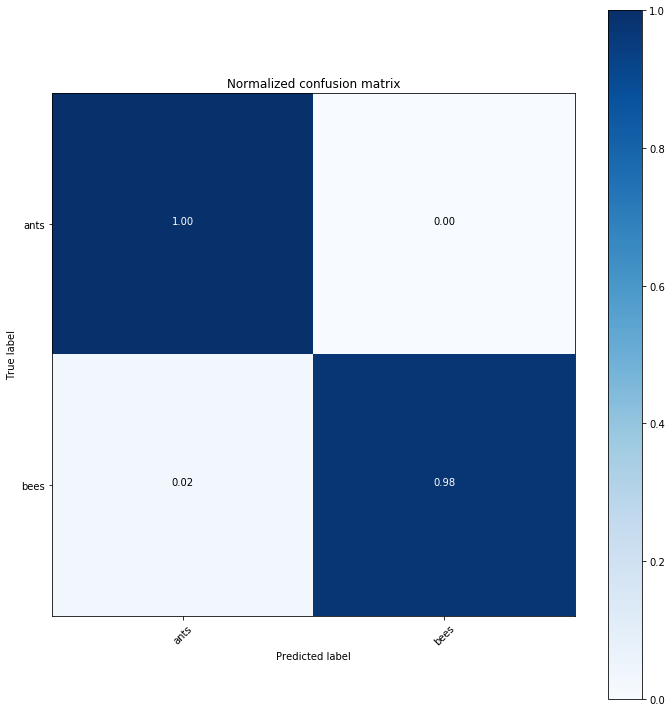

In [ ]:
# Plot normalized confusion matrix
plt.figure(figsize=(10, 10))
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True, title='Normalized confusion matrix')
display()

# 7. Save and Load Model

### 7.1 Save/Load `state_dict`

In [ ]:
# parameters for saving
SAVE_PATH = os.path.join("models", MODEL_NAME + ".pt")

# save model
torch.save(net.state_dict(), SAVE_PATH)

In [17]:
# parameters for loading
MODEL_NAME = "model.pt"
LOAD_PATH = os.path.join("models", MODEL_NAME)

# load model
net, input_size, params_to_update, finalconv_name = initialize_model(MODEL_NAME, NUM_CLASSES)
net.load_state_dict(torch.load(LOAD_PATH))
net.eval()

TypeError: ignored

### 7.2 Save/Load Entire Model

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# parameters for saving
SAVE_PATH = os.path.join("models", MODEL_NAME + ".pt")

# save model
torch.save(net, SAVE_PATH)

In [9]:
# instantiate transfer learning model
resnet_model = models.resnet50(pretrained=True)

# set all paramters as trainable
for param in resnet_model.parameters():
    param.requires_grad = True

# get input of fc layer
n_inputs = resnet_model.fc.in_features

# redefine fc layer / top layer/ head for our classification problem
resnet_model.fc = nn.Sequential(nn.Linear(n_inputs, 2048),
                                nn.SELU(),
                                nn.Dropout(p=0.4),
                                nn.Linear(2048, 2048),
                                nn.SELU(),
                                nn.Dropout(p=0.4),
                                nn.Linear(2048, 4),
                                nn.LogSigmoid())

# set all paramters of the model as trainable
for name, child in resnet_model.named_children():
  for name2, params in child.named_parameters():
    params.requires_grad = True

# set model to run on GPU or CPU absed on availibility
resnet_model.to(device)

# print the trasnfer learning NN model's architecture
resnet_model

The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 76.0MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [13]:
# parameters for loading
LOAD_PATH = "/content/drive/My Drive/phd/bt_resnet50_model.pt" #os.path.join("models", MODEL_NAME)

# load model
# model class must be defined somewhere
# net = torch.load(LOAD_PATH)

resnet_model.load_state_dict(torch.load(LOAD_PATH))

resnet_model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

# 8. Class Activation Mappings

Popular networks that are accessible in the `models` subpackage of `torchvision` already implement global average pooling at the end. This means that heatmaps can be generated directly without modifying the network architecture. We only have to register a hook with `torch.nn.register_forward_hook(hook)` at the last convolutional layer of the respective framework.

In [ ]:
net = net.cpu()

In [ ]:
net.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
      (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stri

In [14]:
features_blobs = []
def hook_feature(module, input, output):
    features_blobs.append(output.data.cpu().numpy())

def register_hook(model, finalconv_name):
    model._modules.get(finalconv_name).register_forward_hook(hook_feature)

In [18]:
finalconv_name = "layer4"
register_hook(resnet_model, finalconv_name)

Now, Class Activation Maps should be generated for sample images.

In [52]:
def return_cam(feature_conv, weight_softmax, class_idx, model_input_size):
    # generate the class activation maps upsample to 256x256
    size_upsample = model_input_size
    bz, nc, h, w = feature_conv.shape
    output_cam = []
    for idx in class_idx:
        cam = weight_softmax[idx].dot(feature_conv.reshape((nc, h*w)))
        cam = cam.reshape(h, w)
        cam = cam - np.min(cam)
        cam_img = cam / np.max(cam)
        cam_img = np.uint8(255 * cam_img)
        output_cam.append(cv2.resize(cam_img, size_upsample))
    return output_cam

def calculate_cam(model, model_input_size, features_blobs, img_read_path, classes):
    # get the softmax weight
    # params = list(model.cpu().parameters())
    params = list(model.parameters())
    weight_softmax = np.squeeze(params[-2].data.numpy())

    # preprocess image
    preprocess = transforms.Compose([
        transforms.Resize(model_input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    img = Image.open(img_read_path)
    img_tensor = preprocess(img)
    img_variable = Variable(img_tensor.unsqueeze(0))

    # get model prediction
    logit = model(img_variable)
    print("logit", logit)
    h_x = F.softmax(logit, dim=1).data.squeeze()
    print(h_x)
    probs, idx = h_x.sort(0, True)
    probs = probs.numpy()
    idx = idx.numpy()
    print("idx",idx)
    # output the prediction
    #end = min(NUM_CLASSES, 5)
    #for i in range(0, end):
    #    print('{:.3f} -> {}'.format(probs[i], classes[idx[i]]))

    # generate class activation mapping for the top1 prediction
    CAMs = return_cam(features_blobs[0], weight_softmax, [idx[0]], model_input_size)

    # render the CAM and output
    #print("Output CAM.jpg for the Top-1 Prediction: %s" % classes[idx[0]])
    img = cv2.resize(cv2.imread(img_read_path), model_input_size)
    height, width, _ = img.shape
    heatmap = cv2.applyColorMap(CAMs[0], cv2.COLORMAP_JET) #cv2.resize(CAMs[0],(width, height)), cv2.COLORMAP_JET)
    result = heatmap * 0.3 + img * 0.5
    cv2.imwrite("CAM.jpg", result)
    del features_blobs[:]
    return Image.open("CAM.jpg"), classes[idx[0]]

In [20]:
def plot_images_cam(paths, model, input_size, features_blobs, class_names, columns=4, rows=5):
    fig = plt.figure(figsize=(15, 15))
    end = min(columns*rows+1, len(paths)+1)
    for i in range(1, end):
        img, pred = calculate_cam(model, input_size, features_blobs, paths[i-1], class_names)
        ax = fig.add_subplot(rows, columns, i)
        ax.title.set_text("Predicted: {}".format(pred))
        ax.set_xticks([])
        ax.set_yticks([])
        plt.imshow(img)
    plt.show()

def create_path_list(base_path):
    path_list = []
    files = os.listdir(base_path)
    for _, file in enumerate(files):
        path_list.append(os.path.join(base_path, file))
    return path_list

## 8.1 Single image

In [21]:
DATA_DIR = "/content/drive/MyDrive/phd/new_dataset/bt_images"
os.listdir(DATA_DIR)
#os.listdir(os.path.join(DATA_DIR, "test", "ants"))

['2108.jpg',
 '2109.jpg',
 '2110.jpg',
 '2111.jpg',
 '2112.jpg',
 '2113.jpg',
 '2114.jpg',
 '2115.jpg',
 '2116.jpg',
 '2117.jpg',
 '2118.jpg',
 '2119.jpg',
 '2120.jpg',
 '2121.jpg',
 '2122.jpg',
 '2123.jpg',
 '2124.jpg',
 '2125.jpg',
 '2126.jpg',
 '2127.jpg',
 '2128.jpg',
 '2129.jpg',
 '2130.jpg',
 '2131.jpg',
 '2132.jpg',
 '2133.jpg',
 '2134.jpg',
 '2135.jpg',
 '2136.jpg',
 '2137.jpg',
 '2138.jpg',
 '2139.jpg',
 '2140.jpg',
 '2141.jpg',
 '2142.jpg',
 '2143.jpg',
 '2144.jpg',
 '2145.jpg',
 '2146.jpg',
 '2147.jpg',
 '2148.jpg',
 '2149.jpg',
 '2150.jpg',
 '2151.jpg',
 '2152.jpg',
 '2153.jpg',
 '2154.jpg',
 '2155.jpg',
 '2156.jpg',
 '2157.jpg',
 '2158.jpg',
 '2159.jpg',
 '2160.jpg',
 '2161.jpg',
 '2162.jpg',
 '2163.jpg',
 '2164.jpg',
 '2165.jpg',
 '2166.jpg',
 '2167.jpg',
 '2168.jpg',
 '2169.jpg',
 '2170.jpg',
 '2171.jpg',
 '2172.jpg',
 '2173.jpg',
 '2174.jpg',
 '2175.jpg',
 '2176.jpg',
 '2177.jpg',
 '2178.jpg',
 '2179.jpg',
 '2180.jpg',
 '2181.jpg',
 '2182.jpg',
 '2183.jpg',
 '2184.jpg',

logit tensor([[-37.2083, -20.7474,  -4.8884, -30.5951]],
       grad_fn=<LogSigmoidBackward0>)
tensor([9.1970e-15, 1.2957e-07, 1.0000e+00, 6.8504e-12])
idx [2 1 3 0]
Predicted class: glioma


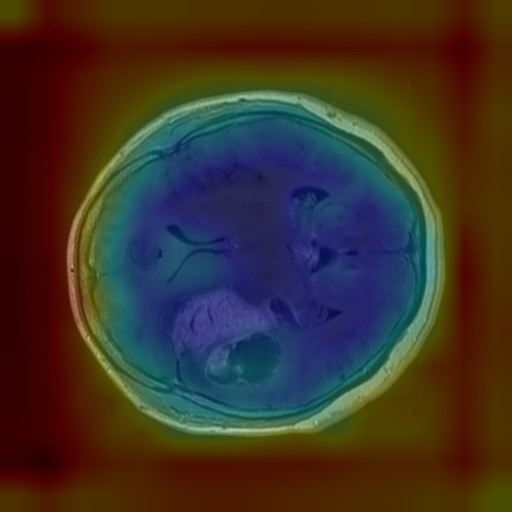

In [53]:
# img_path = os.path.join(DATA_DIR, "test", "ants", "1693954099_46d4c20605.jpg")
img_path = os.path.join(DATA_DIR, "5.jpg")
input_size = (512,512)
class_names = ["meningioma","Pituitary","glioma","abc"]
img, pred = calculate_cam(resnet_model, input_size, features_blobs, img_path, class_names)
print("Predicted class: {}".format(pred))
img

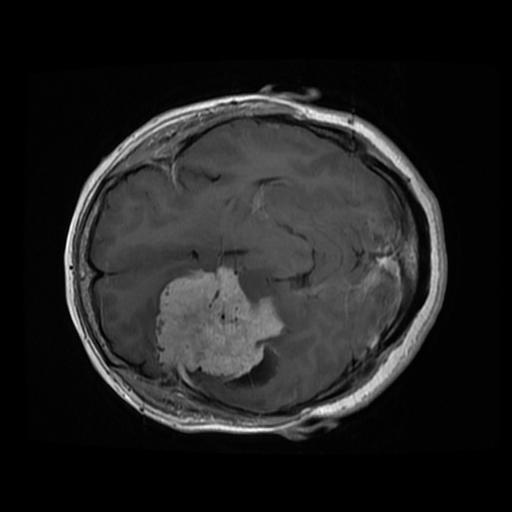

In [45]:
img = Image.open(img_path)
img

## 8.2 Multiple Images

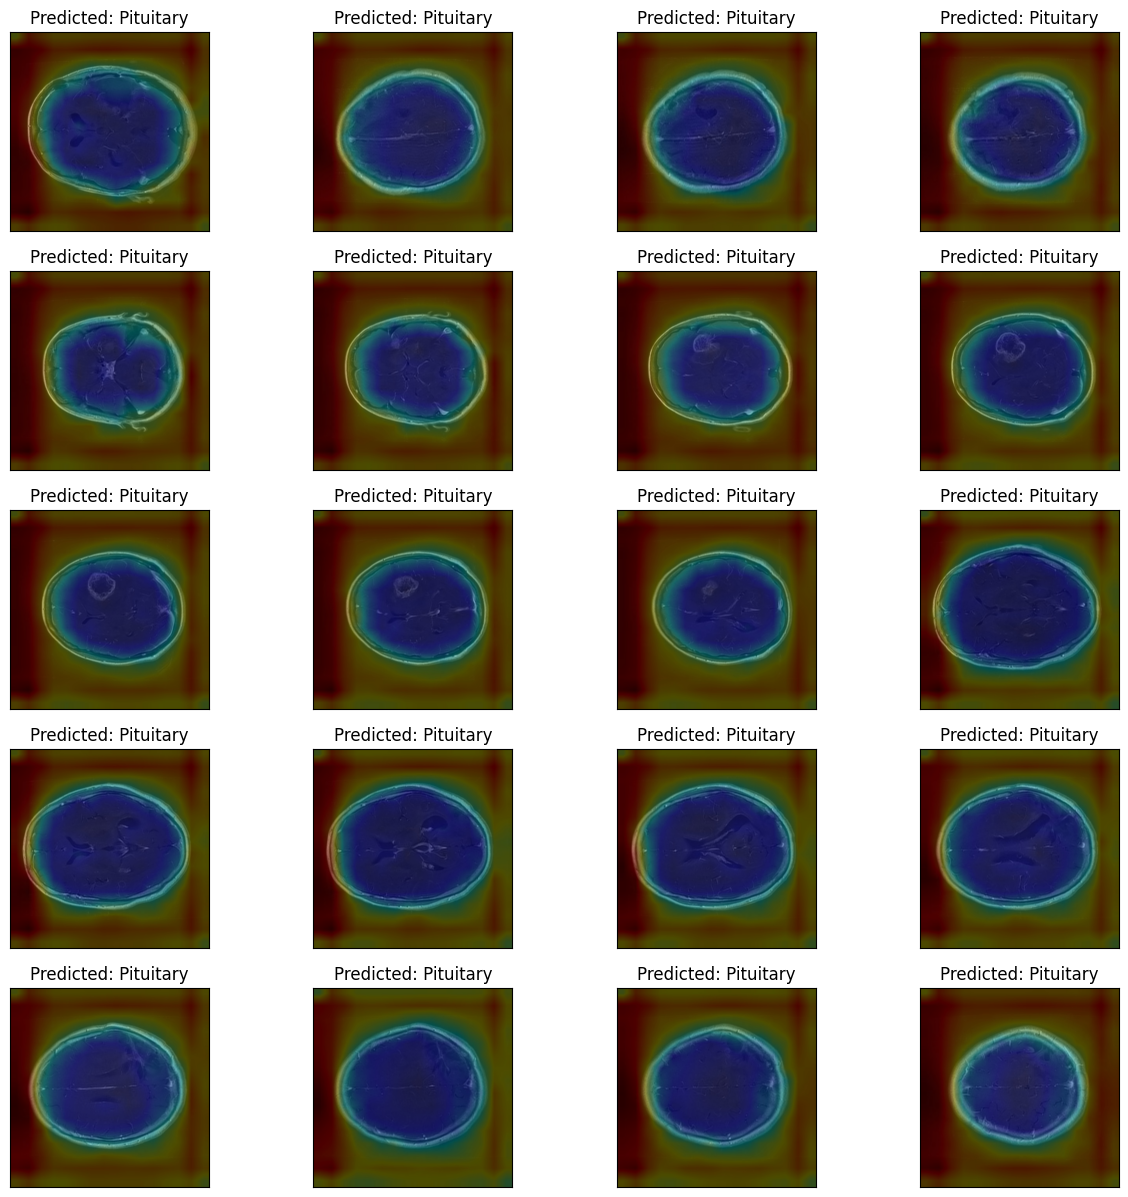

In [43]:
path_list = create_path_list(os.path.join(DATA_DIR))
#path_list = create_path_list(os.path.join("data", "histopathology", "test", "benign"))
plot_images_cam(path_list, resnet_model, input_size, features_blobs, class_names)

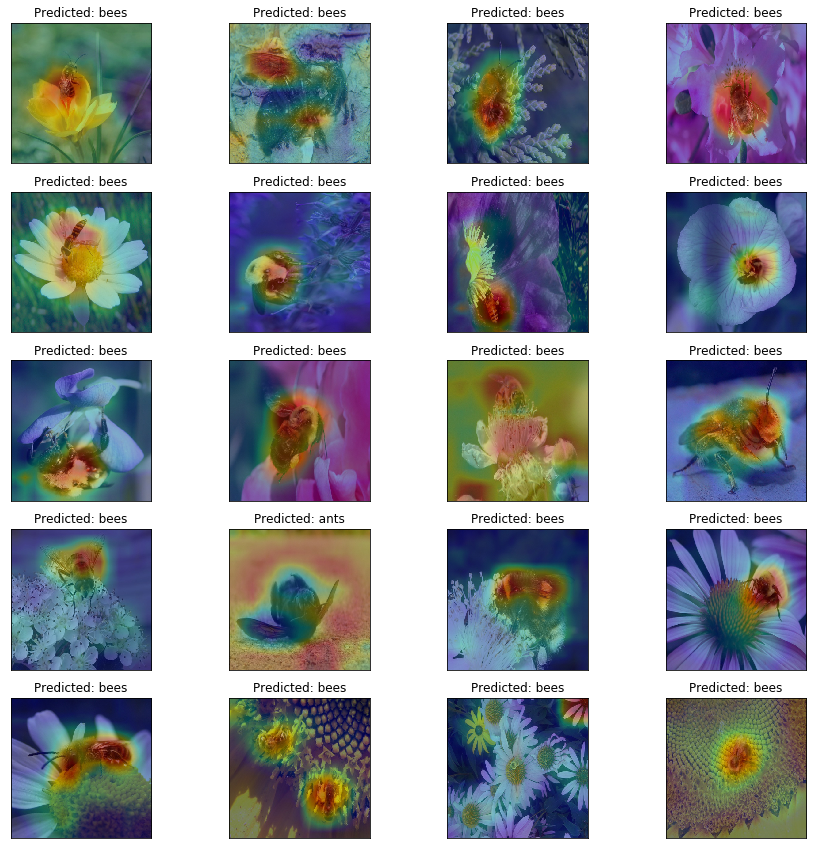

In [ ]:
path_list = create_path_list(os.path.join(DATA_DIR, "test", "bees"))
plot_images_cam(path_list, net, input_size, features_blobs, class_names)

# 9. LIME

Local Interpretable Model-agnostic Explanations (LIME) is about explaining what machine learning classifiers (or models) are doing. As the name suggests, the method is model-agnostic, meaning that it can be used without modifying the trained model itself to explain any black box classifier with two or more classes. Also, the methode produces local explainability, meaning that the method produces explainability for the classification of a single image as the model may be very complex globally. Therefore, it is easier to approximate it around the vicinity of a particular instance. For this, the method produces an array of images from an original input image by using a pertubation algorithm. The method only requires that the classifier implements a function that takes in raw text or a numpy array and outputs a probability for each class. Consequently, two things must be provided to the LIME package to make it work:
1. Original image as numpy array or tensor and
2. A classification function that would take array of purturbed images as input and produce the probabilities for each class for each image as output.

Let us first define the functions for image preprocessing.

In [ ]:
def image_to_tensor_and_normalize(img):
    preprocess = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    return preprocess(img)

def read_image_and_transform(path, model_input_size=input_size, tensor_and_normalize=False):
    img = Image.open(path)
    preprocess = transforms.Compose([
        transforms.Resize(model_input_size)
    ])
    transform = preprocess(img)

    if tensor_and_normalize:
        transform = image_to_tensor_and_normalize(transform)
    return transform

Now, let us define the classification function that LIME requires. The input of this function will be a numpy array of images, whereby each image is ndarray of shape (channel, height, width). The output is numpy array of shape (image index, classes) where each value in array should be probability for that image, class combination.

In [ ]:
def batch_predict(imgs, model=net):
    model.eval()
    batch = torch.stack(tuple(image_to_tensor_and_normalize(i) for i in imgs), dim=0)

    model = model.to(device)
    batch = batch.to(device)

    logits = model(batch)
    probs = F.softmax(logits, dim=1)
    return probs.detach().cpu().numpy()

In [ ]:
os.listdir(os.path.join(DATA_DIR, "test", "ants"))

['1693954099_46d4c20605.jpg',
 '1743840368_b5ccda82b7.jpg',
 '1804095607_0341701e1c.jpg',
 '1808777855_2a895621d7.jpg',
 '1917341202_d00a7f9af5.jpg',
 '1924473702_daa9aacdbe.jpg',
 '2019439677_2db655d361.jpg',
 '2039585088_c6f47c592e.jpg',
 '2104709400_8831b4fc6f.jpg',
 '2127908701_d49dc83c97.jpg',
 '2191997003_379df31291.jpg',
 '2211974567_ee4606b493.jpg',
 '2219621907_47bc7cc6b0.jpg',
 '2238242353_52c82441df.jpg',
 '2255445811_dabcdf7258.jpg',
 '2265824718_2c96f485da.jpg',
 '2265825502_fff99cfd2d.jpg',
 '2278278459_6b99605e50.jpg',
 '2288450226_a6e96e8fdf.jpg',
 '2288481644_83ff7e4572.jpg',
 '2292213964_ca51ce4bef.jpg',
 'Ant-1818.jpg',
 'Ant_1.jpg',
 'F.pergan.28(f).jpg',
 'Hormiga.jpg',
 'MehdiabadiAnt2_600.jpg',
 'Nepenthes_rafflesiana_ant.jpg',
 'VietnameseAntMimicSpider.jpg',
 'ant photos.jpg',
 'ants-devouring-remains-of-large-dead-insect-on-red-tile-in-Stellenbosch-South-Africa-closeup-1-DHD.jpg',
 'army-ants-red-picture.jpg',
 'desert_ant.jpg',
 'formica.jpeg',
 'hormiga_co_p

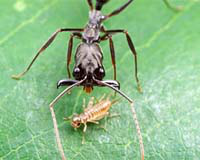

In [ ]:
img_path = os.path.join(DATA_DIR, "test", "ants", "trap-jaw-ant-insect-bg.jpg")
img = Image.open(img_path)
img

Now we can test the functions for a single image.

In [ ]:
img_path = os.path.join(DATA_DIR, "test", "ants", "trap-jaw-ant-insect-bg.jpg")
test_pred = batch_predict([read_image_and_transform(img_path, input_size, False)])
idx = test_pred.squeeze().argmax()
print("Predicted class: {}".format(class_names[idx]))

Predicted class: ants


## 9.1 Single Image

After defining all required functions, we can start using the LIME package for local model explainability.

In [ ]:
explainer = lime_image.LimeImageExplainer(random_state=RANDOM)
explanation = explainer.explain_instance(np.array(read_image_and_transform(img_path, input_size, False)),
                                         batch_predict, # classification function
                                         labels=np.array([0]),
                                         #top_labels=1,
                                         num_features=2,
                                         #hide_color=0,
                                         num_samples=1000,
                                         random_seed=RANDOM) # number of images that will be sent to classification function

In [ ]:
plt.imshow(explanation.segments)

Now we can display the results of LIME.

In [ ]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=False)
img_boundry1 = mark_boundaries(temp/255.0, mask)
plt.imshow(img_boundry1)

In [ ]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=1, hide_rest=True)
img_boundry2 = mark_boundaries(temp/255.0, mask)
plt.imshow(img_boundry2)

In [ ]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=True)
img_boundry3 = mark_boundaries(temp/255.0, mask)
plt.imshow(img_boundry3)

In [ ]:
gigapixels = mark_boundaries(np.zeros((explanation.image.shape)), explanation.segments)
test_img = 0.2 * (explanation.image/255.0) + 0.7 *  img_boundry2 + 0.1 * gigapixels
plt.imshow(test_img)

## 9.2 Multiple Images

Now we can do the same for a set of images.

In [ ]:
def calculate_lime(img_path, input_size, label_to_explain, num_features=3, num_samples=1000):
    explainer = lime_image.LimeImageExplainer()
    return explainer.explain_instance(np.array(read_image_and_transform(img_path, input_size, False)),
                                      batch_predict,
                                      labels=np.array([label_to_explain]),
                                      #top_labels=1,
                                      num_features=num_features,
                                      hide_color=0,
                                      num_samples=num_samples,
                                      random_seed=RANDOM)

def plot_images_lime(paths, input_size, class_names, label_to_explain, num_features=3, num_samples=1000, columns=4, rows=5):
    fig = plt.figure(figsize=(15, 15))
    end = min(columns*rows + 1, len(paths)+1)
    for i in range(1, end):
        explanation = calculate_lime(paths[i-1], input_size, label_to_explain, num_features, num_samples)
        temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=num_features, hide_rest=True)
        gigapixels = mark_boundaries(np.zeros((explanation.image.shape)), explanation.segments)
        img_boundry = mark_boundaries(temp/255.0, mask)
        img = 0.4 * (explanation.image/255.0) + 0.5 * img_boundry + 0.1 * gigapixels
        pred_class = class_names[explanation.top_labels[0]]
        ax = fig.add_subplot(rows, columns, i)
        ax.title.set_text("Predicted: {}".format(pred_class))
        ax.set_xticks([])
        ax.set_yticks([])
        plt.imshow(img)
    plt.show()

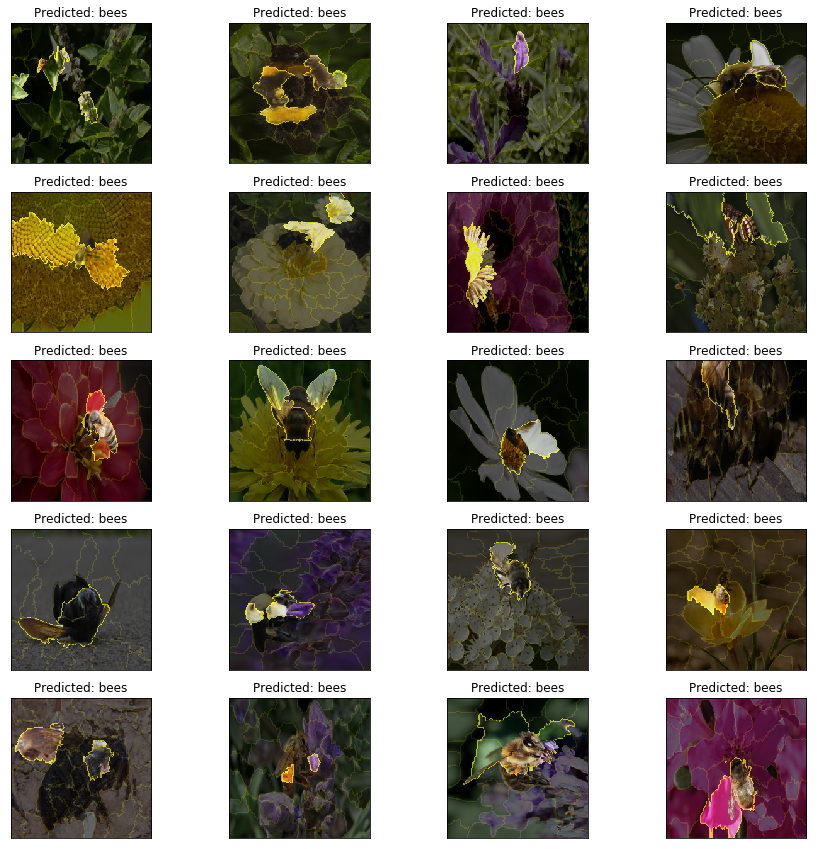

In [ ]:
path_list = create_path_list(os.path.join("hymenoptera_data", "test", "bees"))
plot_images_lime(path_list, input_size, class_names, 1)

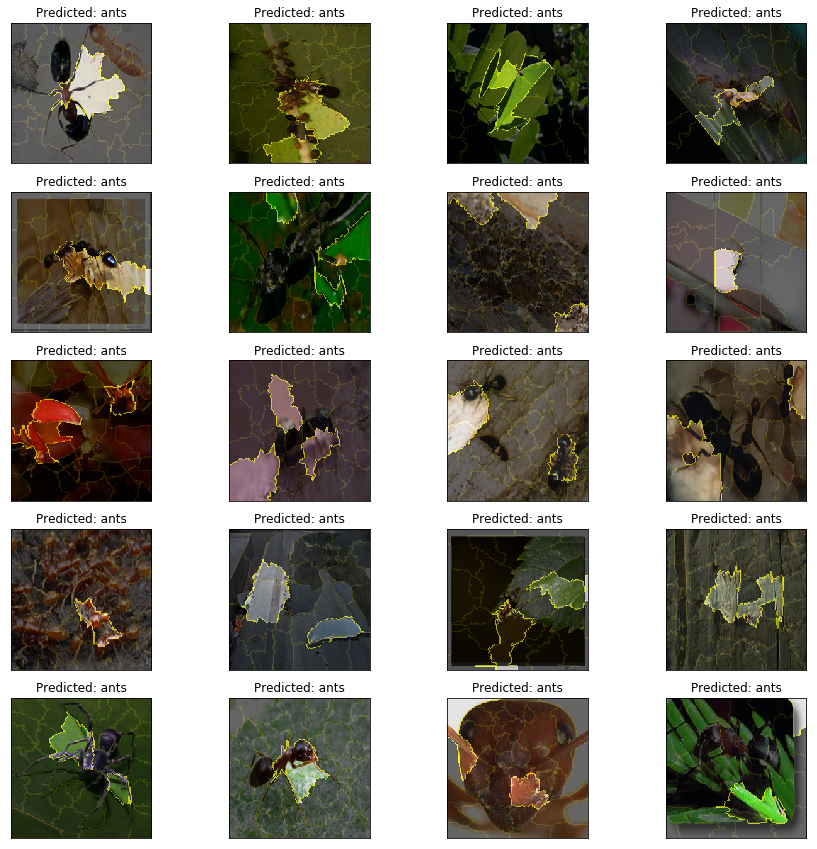

In [ ]:
path_list = create_path_list(os.path.join("hymenoptera_data", "test", "ants"))
plot_images_lime(path_list, input_size, class_names, 0)

# 10. SHapley Additive exPlanations

In [ ]:
inv_normalize = transforms.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
    std=[1/0.229, 1/0.224, 1/0.225]
)

In [ ]:
images, labels = next(iter(dataloaders["test"]))

end = images.shape[0]

background = images[0:end-2]
test_images = images[end-2:end]

e = shap.DeepExplainer(net, background)
shap_values = e.shap_values(test_images)

In [ ]:
shap_numpy = [np.swapaxes(np.swapaxes(s, 1, -1), 1, 2) for s in shap_values]
test_numpy = np.array([inv_normalize(test_images[i]).numpy().transpose((1, 2, 0))
                       for i in range(test_images.shape[0])])

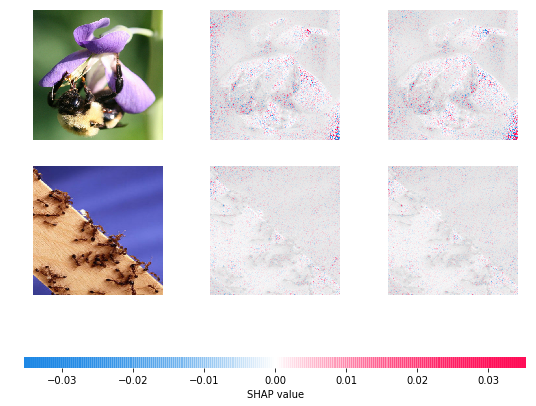

In [ ]:
# plot the feature attributions
shap.image_plot(shap_numpy, test_numpy)

# TODO

* adjust data augmentation
* use BCELoss
* adjust learning rate
* handle different class sizes